In [1]:
!pip install yfinance wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 28.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 331.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 163.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 337.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 193.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 340.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 213.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=843021 sha256=abfba4fb745233e02facaf20473aa264aae72ff1

In [2]:
import yfinance as yf

btc_data = yf.download('BTC-KRW', start='2023-12-01', end='2024-12-01', interval='1d')
btc_data.to_csv('BTC-KRW_raw.csv')

[*********************100%***********************]  1 of 1 completed


In [3]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#체크포인트 경로 설정 및 폴더 만들기
CHECKPOINT_FILE_PATH = os.path.join(os.getcwd(), 'checkpoints_regression')

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)

In [5]:
from utils.utils import strfdelta
from utils.early_stopping import EarlyStopping

class RegressionTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.MSELoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train.squeeze(dim=-1), target_train)

      loss_train += loss.item()

      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains

    return train_loss

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)

        loss_validation += self.loss_fn(output_validation.squeeze(dim=-1), target_validation).item()

        num_validations += 1

    validation_loss = loss_validation / num_validations

    return validation_loss

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 1000 * epoch / elapsed_time.microseconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"V_loss: {validation_loss:7.5f}, "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Validation loss": validation_loss,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")

In [6]:
def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
  btc_krw_path = os.path.join(os.getcwd(), "BTC_KRW.csv")
  df = pd.read_csv(btc_krw_path)
  row_size = len(df)
  # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  date_list = df['Date']

  df = df.drop(columns=['Date'])

  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )

In [7]:
class CryptoCurrencyDataset(Dataset):
  def __init__(self, X, y, is_regression=True):
    self.X = X
    self.y = y

    assert len(self.X) == len(self.y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

In [8]:
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
    sequence_size= sequence_size, validation_size=validation_size, test_size=test_size, target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  ) #데이터 분할
  
  #데이터를 커스텀 dataset에 저장
  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  #dataset을 dataloader에 저장해 배치 단위로 사용할 수 있게 함
  train_data_loader = DataLoader(
    dataset = train_crypto_currency_dataset,batch_size=wandb.config.batch_size,shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset = validation_crypto_currency_dataset,batch_size=wandb.config.batch_size,shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset,batch_size=len(test_crypto_currency_dataset),shuffle=True
  )
  #데이터 로더 반환
  return train_data_loader, validation_data_loader, test_data_loader

In [9]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()
      
      self.lstm=nn.LSTM(input_size = n_input, hidden_size = 128, num_layers = 2, batch_first = True)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)
      
    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:,-1:]
      x = self.fcn(x)
      return x
  
  # 모델을 만들어서 주면 이후로 모델을 다시 만들필요 없으므로 함수 내에서 클래스 선언
  my_model = MyModel(n_input=5, n_output=1)
  return my_model

In [10]:
def main_train(epochs, batch_size, validation_intervals, learning_rate ,early_stop_patience, early_stop_delta, weight_decay):
  run_time_str = datetime.now().astimezone().strftime("%Y_%m_%d_%H_%M_%S")
  
  config = {
    'epochs': epochs,
    'batch_size': batch_size,
    'validation_intervals': validation_intervals,
    'learning_rate': learning_rate,
    'early_stop_patience': early_stop_patience,
    'early_stop_delta': early_stop_delta,
    'weight_decay': weight_decay
  }
  
  project_name = 'lstm_regression_btc_krw'
  wandb.init(
    mode = 'online',
    project =project_name,
    notes = 'btc_krw experiment with lstm',
    tags=["lstm", "regression","btc_krw"],
    name = run_time_str,
    config = config
  )
  
  train_data_loader, validation_data_loader, _=get_btc_krw_data()
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  
  model = get_model()
  model.to(device)
  
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wandb.config.weight_decay)
  
  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None, run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()
  
  wandb.finish()

In [11]:
#test를 위함 함수
def test(test_model):
  _,_, test_data_loader = get_btc_krw_data()
  
  test_model.eval()
  
  y_normalizer= 100
  
  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch 
      output_test = test_model(input_test)
      
    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))

In [12]:
#모든 데이터셋에 대해 예측을 진행하고, 그래프로 표시
def predict_all(test_model):
  y_normalizer= 100
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )
  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)
  
  dataset_list = [
    train_crypto_currency_dataset,validation_crypto_currency_dataset,test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6,9))
  
  for i in range(3):#dataset_list에 들어있는 dataset을 순서대로 예측
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0).squeeze(-1).squeeze(-1))
      
      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)
      
      num += 1
      
    axs[i].plot(X, TARGET_Y, label = 'target')
    axs[i].plot(X, PREDICTION_Y, label = 'prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()
  
  plt.tight_layout()
  plt.show()

In [13]:
def main_test(epochs, batch_size, validation_intervals, learning_rate ,early_stop_patience, early_stop_delta):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
  
  config = {
    'epochs': epochs,
    'batch_size': batch_size,
    'validation_intervals': validation_intervals,
    'learning_rate': learning_rate,
    'early_stop_patience': early_stop_patience,
    'early_stop_delta': early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/work/.netrc
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

[Epoch   1] T_loss: 5.70936, V_loss: 40.05357, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.002
[Epoch  10] T_loss: 5.32291, V_loss: 40.08896, Early stopping counter: 1 out of 10 | T_time: 00:00:04, T_speed: 0.119
[Epoch  20] T_loss: 5.25805, V_loss: 43.82389, Early stopping counter: 2 out of 10 | T_time: 00:00:07, T_speed: 0.021
[Epoch  30] T_loss: 5.26008, V_loss: 40.34819, Early stopping counter: 3 out of 10 | T_time: 00:00:11, T_speed: 0.036
[Epoch  40] T_loss: 5.25311, V_loss: 42.60080, Early stopping counter: 4 out of 10 | T_time: 00:00:15, T_speed: 0.057
[Epoch  50] T_loss: 5.26227, V_loss: 41.63067, Early stopping counter: 5 out of 10 | T_time: 00:00:19, T_speed: 0.088
[Epoch  60] T_loss: 5.26933, V_loss: 39.47575, V_loss decreased (40.05357 --> 39.47575). Saving model... | T_time: 00:00:23, T_speed: 0.140
[Epoch  70] T_loss: 5.29066, V_loss: 40.90744, Early stopping counter: 1 out of 10 | T_time: 00:00:27, T_speed: 0.218
[Epoch  80] T_loss: 5.32411, V_loss: 39.5216

Epoch,▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇██
Training loss,█▂▁▁▁▁▁▂▂▂▁▁▂▁▁▁▂
Training speed (epochs/sec.),▁▂▁▁▁▁▂▂▃█▂▂▂▂▃▄█
Validation loss,▂▂█▂▆▄▁▃▁▄▅▆▄▁▆▄▆
Epoch,160
Training loss,5.28627
Training speed (epochs/sec.),1.46675
Validation loss,42.35823


MODEL FILE: /home/work/DL/4/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 232.33 <--> 1,125.35 (Loss:        893.01)
 1: 230.78 <--> 1,059.85 (Loss:        829.07)
 2: 235.33 <--> 1,224.73 (Loss:        989.40)
 3: 235.85 <--> 1,334.58 (Loss:      1,098.73)
 4: 235.77 <--> 1,331.62 (Loss:      1,095.85)
 5: 236.15 <--> 1,373.29 (Loss:      1,137.14)
 6: 234.91 <--> 1,259.24 (Loss:      1,024.34)
 7: 235.24 <--> 1,319.45 (Loss:      1,084.21)
 8: 232.28 <--> 1,070.26 (Loss:        837.98)
 9: 232.44 <--> 1,073.52 (Loss:        841.08)
10: 231.19 <--> 959.09 (Loss:        727.91)
11: 234.10 <--> 1,238.69 (Loss:      1,004.60)
12: 235.97 <--> 1,390.43 (Loss:      1,154.46)
13: 235.99 <--> 1,284.38 (Loss:      1,048.39)
14: 235.71 <--> 1,360.09 (Loss:      1,124.39)
15: 235.18 <--> 1,264.13 (Loss:      1,028.95)
16: 235.02 <--> 1,254.02 (Loss:      1,019.00)
17: 230.67 <--> 957.10 (Loss:        726.43)
18: 231.18 <--> 956.43 (Loss:        725.24)
19: 235.96 <--> 

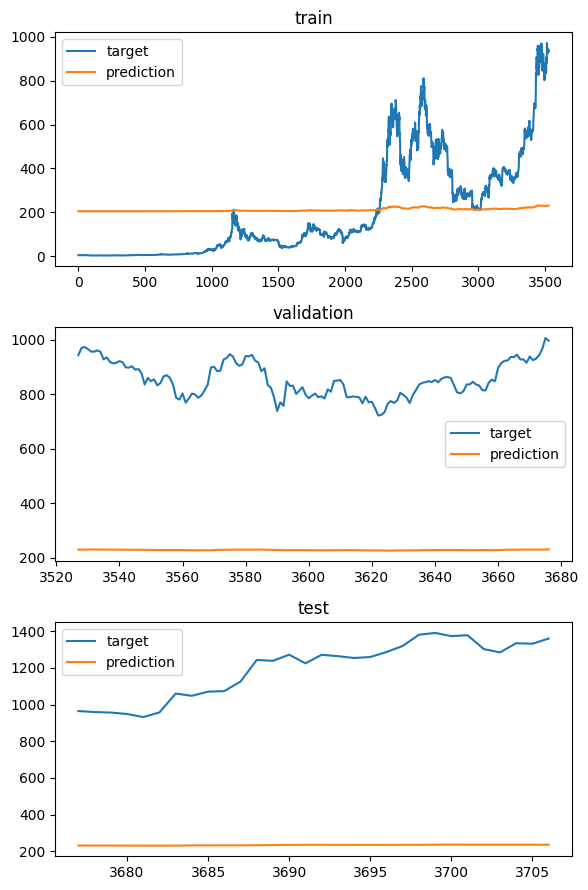

In [14]:
if __name__ == '__main__':
    epochs = 1000
    batch_size = 32
    validation_intervals = 10
    learning_rate = 1e-3
    early_stop_patience = 10
    early_stop_delta = 0.00001
    weight_decay  = 0.001
  
    main_train(epochs, batch_size, validation_intervals, learning_rate,early_stop_patience, early_stop_delta, weight_decay)
    main_test(epochs, batch_size, validation_intervals, learning_rate, early_stop_patience, early_stop_delta)
        

출력결과를 보면 train, validation, test모두 차이가 많이 나며 예측 결과가 거의 일직선을 그린다.
